모듈 불러오기

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from keras.applications.vgg19 import VGG19
from keras.layers import Dense , Conv2D , MaxPooling2D , Dropout, Flatten 
from keras.layers import Dense , GlobalAveragePooling2D
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

경로 설정

In [3]:
data_dir = pathlib.Path('./music/')
data_dir

WindowsPath('music')

배치 및 이미지 사이즈 설정

In [4]:
batch_size = 8
img_height = 653
img_width = 979

데이터 분할

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 9431 files belonging to 6 classes.
Using 6602 files for training.
Found 9431 files belonging to 6 classes.
Using 2829 files for validation.


In [6]:
train_ds

<BatchDataset shapes: ((None, 653, 979, 3), (None,)), types: (tf.float32, tf.int32)>

In [7]:
val_ds

<BatchDataset shapes: ((None, 653, 979, 3), (None,)), types: (tf.float32, tf.int32)>

레이블 값 지정

In [8]:
class_names = train_ds.class_names
print(class_names)

['POP', 'R&B_Soul', '랩_힙합', '록_메탈', '발라드', '일렉트로니카']


데이터 증강

In [9]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

데이터 표준화

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

분류 헤드 추가

In [11]:
global_average_layer = GlobalAveragePooling2D()

전이 학습 불러오기

In [12]:
base_model = VGG19(input_shape=(img_height, img_width , 3), include_top=False, weights='imagenet')

base_model.trainable = False

In [13]:
VGGmodel2 = tf.keras.Sequential([
#     normalization_layer,
#     data_augmentation,
    base_model,
    global_average_layer,
    Flatten(),
    Dense(64,activation="relu"),
    Dense(16,activation="relu"),
    Dense(len(class_names), activation="softmax")
])

In [14]:
VGGmodel2.compile(loss="sparse_categorical_crossentropy",optimizer = "adam", metrics=["accuracy"])

In [15]:
learning_rate_reduction=ReduceLROnPlateau(monitor= "val_loss", patience = 3, factor = 0.5, min_lr=0.0001, verbose=1)


In [16]:
arly_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/text_model.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

In [ ]:
history= VGGmodel2.fit(train_ds,
                       validation_data = val_ds,
                       epochs=50,
                       callbacks=[arly_stopping_callback,checkpointer]
                      )

Epoch 1/50
108/826 [==>...........................] - ETA: 5:47 - loss: 1.7498 - accuracy: 0.2396

<Figure size 1200x400 with 0 Axes>

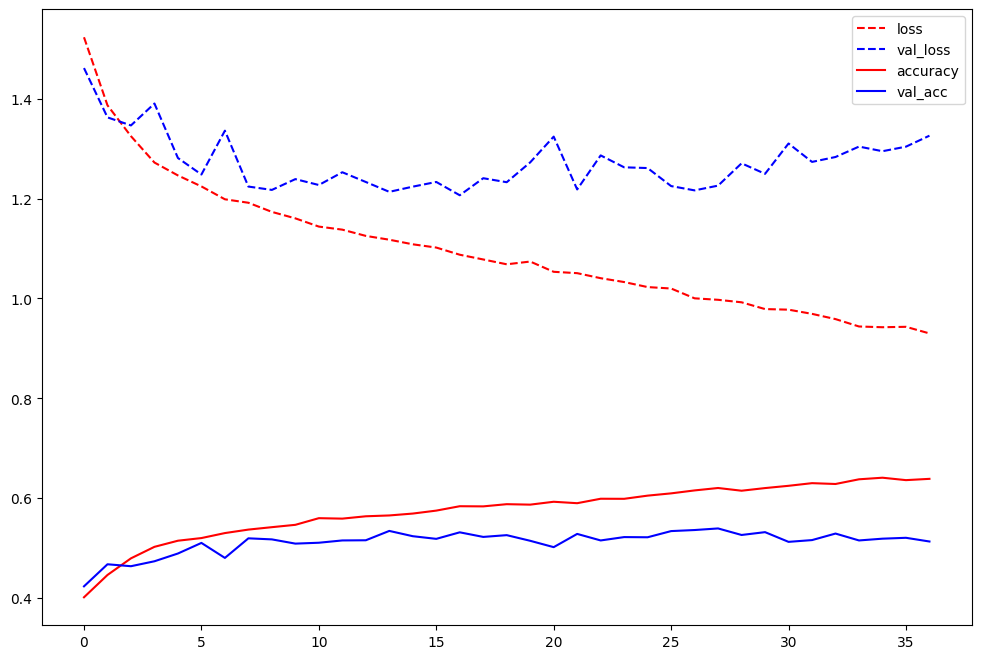

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='red')
plt.plot(history.history['val_accuracy'],c='blue')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [23]:
VGGmodel2.evaluate(val_ds)

354/354 [==============================] - 174s 492ms/step - loss: 1.3260 - accuracy: 0.5133


[1.3260347843170166, 0.5132555961608887]

(653, 979, 3)
(1, 653, 979, 3)
 록_메탈: 24.10 


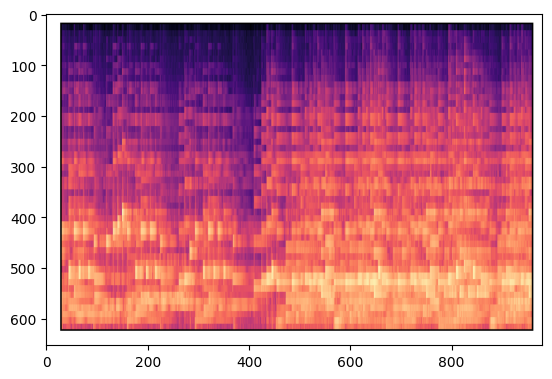

In [24]:
import keras

sunflower_url = "./test.png"


img = keras.preprocessing.image.load_img(
    sunflower_url, target_size=(img_height, img_width)
)

plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions = VGGmodel2.predict(img_array)


score = tf.nn.softmax(predictions[0])
score
print(
    " {}: {:.2f} "
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)